In [ ]:
%pylab inline
%pip install ucimlrepo

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# ライブラリの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import torchvision.utils
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
# 必要なデータセットの読み込み
# データの取得
X, y = torch.load('/content/drive/MyDrive/class/ML/model/2labels_crown_flip.pt')
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=42)
# データの前処理
class Dataset(data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# テンソルへの変換と標準化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# データのロード
#train_dataset = Dataset(train_data, train_labels, transform=transform)
#test_dataset = Dataset(test_data, test_labels, transform=transform)
#train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)
#test_loader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
print("train_data.shape :")
print(train_data.shape)
print("train_labels.shape :")
print(train_labels.shape)

# モデルの定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #pooling:特徴量を減らす
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 33 * 33, 120)
        self.dropout2  = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        #x = self.pool(self.relu(self.conv1(x)))
        #x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 33 * 33)
        #print(x.shape)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        #print(x.shape)
        x = self.dropout2(x)
        x = self.fc2(x)
        #print(x.shape)
        return x



train_data.shape :
torch.Size([1280, 3, 128, 128])
train_labels.shape :
torch.Size([1280])


In [16]:
# モデルの初期化
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングループ
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}], Loss: {running_loss/len(train_loader):.4f}')
    return running_loss / len(train_loader)

# 評価
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')
    return 100 * correct / total

# 学習の実行
num_epochs = 50
train_losses = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    test_accuracy = evaluate(model, test_loader)
    test_accuracies.append(test_accuracy)


Epoch [1], Loss: 0.3690
Accuracy: 96.96%
Epoch [2], Loss: 0.1186
Accuracy: 96.25%
Epoch [3], Loss: 0.0647
Accuracy: 98.71%
Epoch [4], Loss: 0.0269
Accuracy: 98.24%
Epoch [5], Loss: 0.0195
Accuracy: 99.53%
Epoch [6], Loss: 0.0166
Accuracy: 99.30%
Epoch [7], Loss: 0.0077
Accuracy: 99.18%
Epoch [8], Loss: 0.0030
Accuracy: 99.65%
Epoch [9], Loss: 0.0040
Accuracy: 98.83%
Epoch [10], Loss: 0.0099
Accuracy: 98.95%
Epoch [11], Loss: 0.0216
Accuracy: 99.41%
Epoch [12], Loss: 0.0128
Accuracy: 99.77%
Epoch [13], Loss: 0.0036
Accuracy: 99.65%
Epoch [14], Loss: 0.0042
Accuracy: 99.53%
Epoch [15], Loss: 0.0113
Accuracy: 99.41%
Epoch [16], Loss: 0.0048
Accuracy: 99.77%
Epoch [17], Loss: 0.0011
Accuracy: 99.88%
Epoch [18], Loss: 0.0038
Accuracy: 99.77%
Epoch [19], Loss: 0.0136
Accuracy: 99.53%
Epoch [20], Loss: 0.0021
Accuracy: 99.65%
Epoch [21], Loss: 0.0006
Accuracy: 99.77%
Epoch [22], Loss: 0.0006
Accuracy: 99.65%
Epoch [23], Loss: 0.0037
Accuracy: 98.83%
Epoch [24], Loss: 0.0014
Accuracy: 99.18%
E

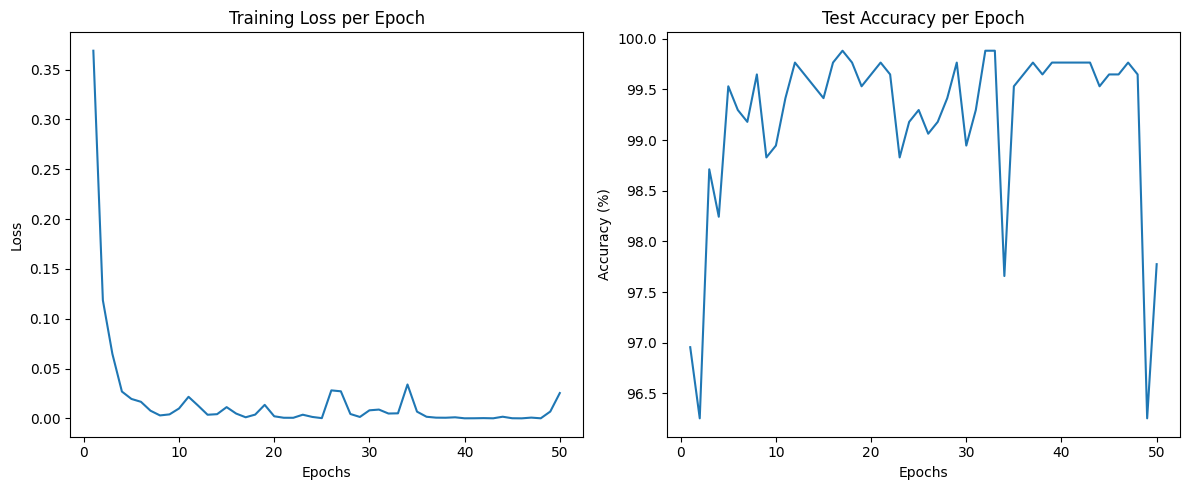

In [17]:
# 結果の描画
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
#plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
#plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# モデルの保存
torch.save(model.state_dict(), '/content/drive/MyDrive/class/ML/model/2labels_model_.pth')

In [19]:
model.load_state_dict(torch.load('/content/drive/MyDrive/class/ML/model/2labels_model_.pth'))

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 画像の前処理
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 画像の読み込みと変換
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # バッチサイズの次元を追加
    return image

# 画像の予測
def predict(model, image_path):
    image = load_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()


In [ ]:
import os
from PIL import Image
import pandas as pd
# テスト画像のパス
path = "/content/drive/MyDrive/class/ML/test/"
folders = ["normal", "police"]

# 予測結果を格納するためのリスト
results = []

# image directory以下にある画像群に対して実行
for folder in folders:
    image_path = os.path.join(path, folder)
    for filename in os.listdir(image_path):
        file_path = os.path.join(image_path, filename)
        predicted_label = predict(model, file_path)  # predit -> predict
        results.append([folder, filename, predicted_label])

# 結果をデータフレームに変換
df_results = pd.DataFrame(results, columns=['Folder', 'Filename', 'Predicted Label'])

# フォルダごとの結果の表示
for folder in folders:
    df_folder = df_results[df_results['Folder'] == folder]
    print(f"Results for folder: {folder}")
    print(df_folder)
    print("\n")

    # グラフの描画
    num_images = len(df_folder)
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
    fig.suptitle(f'Predictions for {folder} crown', fontsize=16)

    for i, (index, row) in enumerate(df_folder.iterrows()):
        ax = axes[i // 3, i % 3]
        file_path = os.path.join(path, row['Folder'], row['Filename'])
        image = Image.open(file_path)
        ax.imshow(image)
        ax.set_title(f'Predicted: {folders[row["Predicted Label"]]}')
        ax.axis('off')

    # 残りの空のプロットを非表示にする
    for j in range(num_images, 12):
        fig.delaxes(axes[j // 3, j % 3])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust the top to fit the suptitle
    plt.show()